# Agenda
Spectral clustering of GPs' bitmaps.



In [1]:
# Installing Libraries (if not installed)
#!pip3 install jupyterlab-git
#!pip3 install matplotlib
#!pip3 install scikit-learn
#!pip3 install seaborn
#!pip3 install numpy
#!pip3 install pandas
#!pip3 install so4gp
#!pip3 install scipy
#!pip3 install sympy

# Import libraries <a name="lib-import"></a>

In [2]:
# Importing Libraries
import pandas as pd
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import sympy
import scipy
import math


from scipy.sparse import csgraph, csr_matrix
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import kneighbors_graph
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import homogeneity_score, completeness_score,v_measure_score, confusion_matrix, accuracy_score
from numpy import linalg as la

In [3]:
import so4gp as sgp

## Data set
Retrieving data set and the features

In [4]:
#ds = sgp.DataGP('../data/DATASET.csv')
#ds = sgp.DataGP('../data/c2k_02k.csv')
ds = sgp.DataGP('../data/breast_cancer.csv')


data_size = ds.row_count
features = np.array(ds.data, dtype=np.float64)
features

array([[ 48.        ,  23.5       ,  70.        , ...,   7.99585   ,
        417.114     ,   1.        ],
       [ 83.        ,  20.69049454,  92.        , ...,   4.06405   ,
        468.786     ,   1.        ],
       [ 82.        ,  23.12467037,  91.        , ...,   9.27715   ,
        554.697     ,   1.        ],
       ...,
       [ 65.        ,  32.05      ,  97.        , ...,  10.33      ,
        314.05      ,   2.        ],
       [ 72.        ,  25.59      ,  82.        , ...,   3.27      ,
        392.46      ,   2.        ],
       [ 86.        ,  27.18      , 138.        , ...,   4.35      ,
         90.09      ,   2.        ]])

In [5]:
sgp.graank('../data/breast_cancer.csv', min_sup=0.6)

'{"Algorithm": "GRAANK", "Patterns": [[["BMI+", "Insulin+"], 0.612], [["BMI+", "HOMA+"], 0.614], [["BMI+", "Leptin+"], 0.732], [["BMI-", "Insulin-"], 0.612], [["BMI-", "HOMA-"], 0.614], [["Leptin-", "BMI-"], 0.732], [["Insulin+", "Glucose+"], 0.637], [["HOMA+", "Glucose+"], 0.697], [["Glucose-", "Insulin-"], 0.637], [["Glucose-", "HOMA-"], 0.697], [["HOMA+", "Insulin+"], 0.94], [["Insulin+", "Leptin+"], 0.659], [["HOMA-", "Insulin-"], 0.94], [["Leptin-", "Insulin-"], 0.659], [["HOMA+", "Leptin+"], 0.659], [["Leptin-", "HOMA-"], 0.659], [["MCP.1+", "Resistin+"], 0.672], [["MCP.1-", "Resistin-"], 0.672], [["HOMA+", "Insulin+", "Glucose+"], 0.637], [["Glucose-", "HOMA-", "Insulin-"], 0.637], [["HOMA+", "Insulin+", "Leptin+"], 0.629], [["Leptin-", "HOMA-", "Insulin-"], 0.629]]}'

In [6]:
feature_X = features[:, [1,3]]
feature_X

array([[23.5       ,  2.707     ],
       [20.69049454,  3.115     ],
       [23.12467037,  4.498     ],
       [21.36752137,  3.226     ],
       [21.11111111,  3.549     ],
       [22.85445769,  3.226     ],
       [22.7       ,  4.69      ],
       [23.8       ,  6.47      ],
       [22.        ,  3.35      ],
       [23.        ,  4.952     ],
       [21.47      ,  3.469     ],
       [23.01      ,  5.663     ],
       [22.86      ,  4.09      ],
       [18.67      ,  6.107     ],
       [23.34      ,  5.782     ],
       [20.76      ,  7.553     ],
       [22.03      ,  2.869     ],
       [32.03895937, 18.077     ],
       [34.5297228 ,  4.427     ],
       [36.51263743, 14.026     ],
       [28.57667585,  4.345     ],
       [31.97501487,  4.53      ],
       [32.27078777,  5.81      ],
       [30.27681661,  4.376     ],
       [30.48315806,  5.537     ],
       [37.03560819,  6.76      ],
       [38.57875854,  6.703     ],
       [31.44654088,  9.245     ],
       [35.2507611 ,

## Semi-Supervised Learning

Train similirity labels

### a. Retrieving training data set (X, y)

In [7]:
def compute_nz(row, i, val=0):
    #print(row[i:])
    nz = np.nonzero(row)
    for k in range(nz[0].size):
        if nz[0].size > 0:
            j = nz[0][k]
            if (j > i) and (val == 0):
                return j
            elif (j > i) and (row[j] == val):
                return j
    return 0

In [8]:
def compute_path(j, X, path, path_val):
    if type(path) != list:
        # 1st iteration
        return compute_path(j, X, [path, j], path_val)
    
    k = compute_nz(X[j],j,val=path_val)
    j += 1
    if k > 0:
        path.append(k)
        if k < data_size:
            return compute_path(k, X, path, path_val)
    elif j < data_size:
        return compute_path(j, X, path, path_val)
    else:
        return path
    

In [21]:
# X (2 features at a time)
X = np.zeros((data_size, data_size))
y  = np.zeros((data_size,))
enc = {"upup": 1, "updown": 2}

for i in range(data_size):
    for j in range(data_size):
        x_i = feature_X[i]
        x_j = feature_X[j]
        if i == j:
            pass
        elif (x_i[0] > x_j[0]) and (x_i[1] > x_j[1]):
            X[i][j] = enc["upup"]
            X[j][i] = enc["upup"]
        elif (x_i[0] > x_j[0]) and (x_i[1] < x_j[1]):
            X[i][j] = enc["updown"]
            X[j][i] = enc["updown"]

longest_path = []
longest_path_val = 0

for i in range(data_size):
    # Column i, Row j
    path_val = enc["upup"]
    #path_val = enc["updown"]
    j = compute_nz(X[i],i, val=path_val)
    if j > 0:
        # path_val = X[i][j]
        path = compute_path(j, X, i, path_val)
        if len(path) > len(longest_path):
            longest_path = path
            longest_path_val = path_val
y[longest_path] = longest_path_val

print(longest_path)
print("\n")
X

[1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 14, 16, 17, 20, 21, 22, 23, 24, 25, 29, 30, 32, 34, 35, 38, 40, 42, 43, 47, 48, 49, 50, 51, 53, 54, 55, 56, 59, 62, 63, 65, 68, 71, 72, 74, 78, 83, 85, 86, 88, 93, 95, 97, 98, 101, 102, 104, 106, 107, 108, 109, 110, 111, 113, 114, 115]




array([[0., 2., 2., ..., 1., 1., 1.],
       [2., 0., 1., ..., 1., 2., 1.],
       [2., 1., 0., ..., 1., 2., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 2.],
       [1., 2., 2., ..., 1., 0., 1.],
       [1., 1., 1., ..., 2., 1., 0.]])

In [22]:
#y  = np.array([2,2,2,2,2], dtype=int)
print(y)

[0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1.
 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1.
 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]


### b. Splitting Samples

Splitting test (20%) and train samples (80%) 

In [23]:
# Splitting the dataset into the Training set (0.5 of data set sample) and Test set (0.5 of sample size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
#X_train, X_test, y_train, y_test = train_test_split(feature_X, y, test_size = 0.50, random_state = 0)


In [24]:
# Feature Scaling (if you have large values otherwise skip)

#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

### c. Constructing KNN Classifier

Using supervised learning

Adopted from [Analyticsvidhya](https://www.analyticsvidhya.com/blog/2021/01/a-quick-introduction-to-k-nearest-neighbor-knn-classification-using-python/)

In [25]:
# Training the K-NN model on the Training set
n = int(math.sqrt(data_size))
knn_classifier = KNeighborsClassifier(n_neighbors = n, metric = 'minkowski', p = 2)  # default parameters
knn_classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = knn_classifier.predict(X_test)
y_pred

array([1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1.])

In [26]:
# Making the Confusion Matrix
confusion_matrix(y_test, y_pred), accuracy_score(y_test, y_pred)

(array([[ 4,  5],
        [ 3, 12]], dtype=int64),
 0.6666666666666666)

### d. Constructing Naive Bayes Classifier

In [27]:
# Training the NB model on the Training set
nb_classifier = CategoricalNB()
nb_classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = nb_classifier.predict(X_test)
y_pred

array([1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 1.])

In [28]:
# Making the Confusion Matrix
confusion_matrix(y_test, y_pred), accuracy_score(y_test, y_pred)

(array([[ 5,  4],
        [ 2, 13]], dtype=int64),
 0.75)

## Proposed Approach
1. We will have to decompose superset GPs into their individual 2x2 subsets and compute their supports through clustering. 

2. Then, we apply antimonotonicity principle to infer the support of the superset.

## a. KMeans Classification
Produces labels that are not very accurate in partitioning data points.

(array([0., 1.]), array([48, 68], dtype=int64))
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0.]


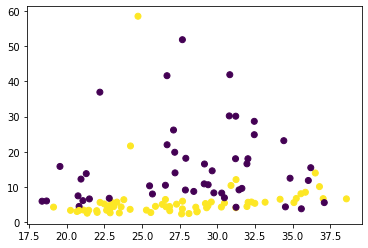

In [29]:
# Validation
# Using KMeans classification (NOT VERY  ACCURATE)

kmean_labels = knn_classifier.predict(X)
print(np.unique(kmean_labels, return_counts=True))
print(kmean_labels)

plt.scatter(feature_X[:,0], feature_X[:,1], c=kmean_labels)
#plt.scatter(feature_X[:,0], feature_X[:,1], c=y )

plt.show()

In [30]:
# Evaluation of clustering result of KMeans (true_labels, predicted_labels)
homogeneity_score(y, kmean_labels), completeness_score(y, kmean_labels), v_measure_score(y, kmean_labels), accuracy_score(y, kmean_labels)#, confusion_matrix(y, kmean_labels)

(0.0800628718783907,
 0.08069974268041899,
 0.08038004577834133,
 0.6724137931034483)

## Naive Bayes Classification

Produces labels

(array([0., 1.]), array([52, 64], dtype=int64))
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1.
 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]


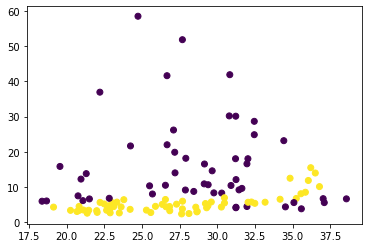

In [31]:
# Validation
# Using Naive Bayes classification

nb_labels = nb_classifier.predict(X)
print(np.unique(nb_labels, return_counts=True))
print(nb_labels)

plt.scatter(feature_X[:,0], feature_X[:,1], c=nb_labels)
#plt.scatter(feature_X[:,0], feature_X[:,1], c=y )

plt.show()

In [32]:
# Evaluation of clustering result of KMeans (true_labels, predicted_labels)
homogeneity_score(y, nb_labels), completeness_score(y, nb_labels), v_measure_score(y, nb_labels), accuracy_score(y, nb_labels)#, confusion_matrix(y, kmean_labels)

(0.10234245958001503,
 0.10172010165271804,
 0.10203033157067355,
 0.6896551724137931)